In [1]:
import pyro
from pyro import distributions as dist
import pyro.distributions.constraints as constraints
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
import pyro.contrib.gp as gp
from sklearn.datasets import fetch_olivetti_faces
from tqdm.autonotebook import tqdm


In [2]:
pyro.clear_param_store()

In [3]:
x_train, y_train = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=97)


In [4]:
Y = (x_train.T)*255
Y = Y.astype(int)
Y = torch.tensor(Y)

In [5]:
idx = torch.linspace(-5, 5, 64, dtype=torch.float)
X_coordinates = torch.cartesian_prod(idx, idx)

In [6]:
N, D = Y.shape
L = 20

def model(data):

    W = pyro.param("W", torch.rand(D, L), constraint=constraints.positive)
    kernel_lengthscale = pyro.param("kernel_lengthscale", torch.tensor([1]), constraint=constraints.positive)
    kernel_variance = pyro.param("kernel_variance", torch.tensor([1]), constraint=constraints.positive)

    kernel = gp.kernels.Matern32(
    input_dim=2, variance=kernel_variance, lengthscale=kernel_lengthscale)


    mu = pyro.param("F_mu", torch.zeros(L, N))
    noise= pyro.param("F_noise", torch.ones([1]), constraint=constraints.positive)

    ch_cov = torch.linalg.cholesky(kernel.forward(X_coordinates)+ noise.expand(N).diag())

    with pyro.plate("F_plate_L", L):
        F = pyro.sample("F", dist.MultivariateNormal(mu, scale_tril=ch_cov))


    F_exp = torch.exp(F.T)
    v = pyro.param("v", torch.ones(N,1), constraint=constraints.positive)
    mu = F_exp@W.T

    with pyro.plate("Y_plate_N", N):
        Y = pyro.sample("Y", dist.Poisson(v*mu).to_event(1), obs=data)

    return W, F, kernel

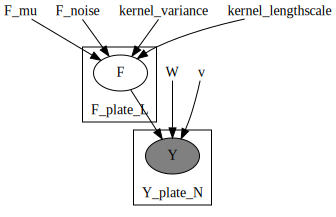

In [7]:
data = torch.ones(N, D)
pyro.render_model(model, model_args=(data,), render_params=True)

In [8]:
def guide(data):
    mean_q = pyro.param("mean_q", torch.zeros((L, N)))
    sigma_q = pyro.param("sigma_q", torch.ones((L, N)),
                        constraint=constraints.positive)

    
    with pyro.plate("F_plate_L", L):
        F = pyro.sample("F", dist.Normal(mean_q, sigma_q).to_event(1))

    return mean_q, sigma_q

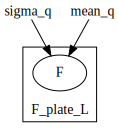

In [9]:
pyro.render_model(guide, model_args=(data,), render_params=True)

In [10]:
adam_params = {"lr": 1e-2, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

In [11]:
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [26]:
# do gradient steps
losses = []
for step in tqdm(range(1500)):
    elbo = svi.step(Y)
    losses.append(elbo)

  0%|          | 0/1500 [00:00<?, ?it/s]

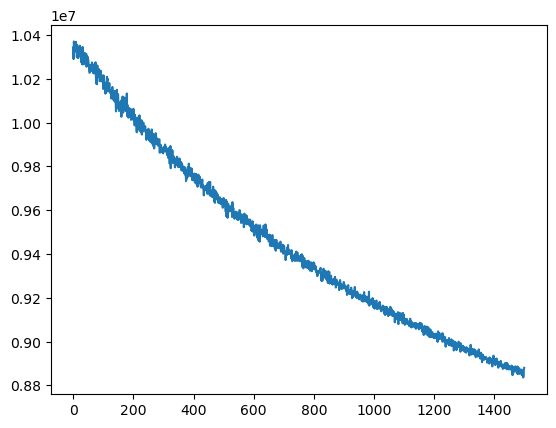

In [27]:
plt.plot(losses)

In [28]:
serving_model = infer_discrete(model, first_available_dim=-1)
W, F, kernel = serving_model(Y)

In [92]:
qF, _ = guide(Y)
qF = qF.T

f = (1/(qF.exp()).sum(axis=0)).diag()

F_post = qF.exp() @ f

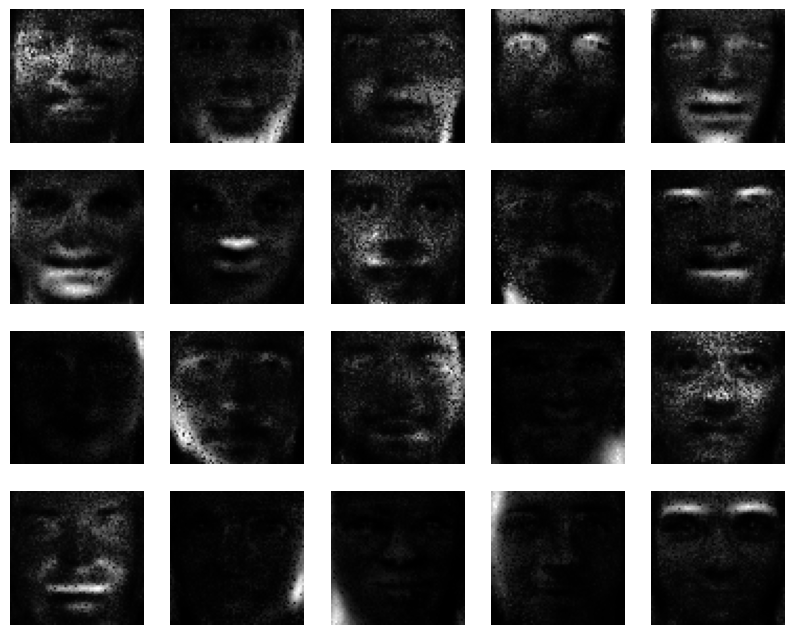

In [96]:
plt.figure(figsize=(10, 8))
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    loading = F_post[:, i].detach().cpu().numpy()
    plt.imshow(loading.reshape(64, 64), cmap='gray')
    plt.axis('off')

In [103]:
qF, _ = guide(Y)

newN = 100
idx = torch.linspace(-6, 6, newN, dtype=torch.float)
U_coordinates = torch.cartesian_prod(idx, idx)

K21 = kernel.forward(U_coordinates, X_coordinates)
K11 = kernel.forward(X_coordinates, X_coordinates) + 1e-3*torch.eye(N)

prediction = K21 @ torch.inverse(K11)@(qF.T)


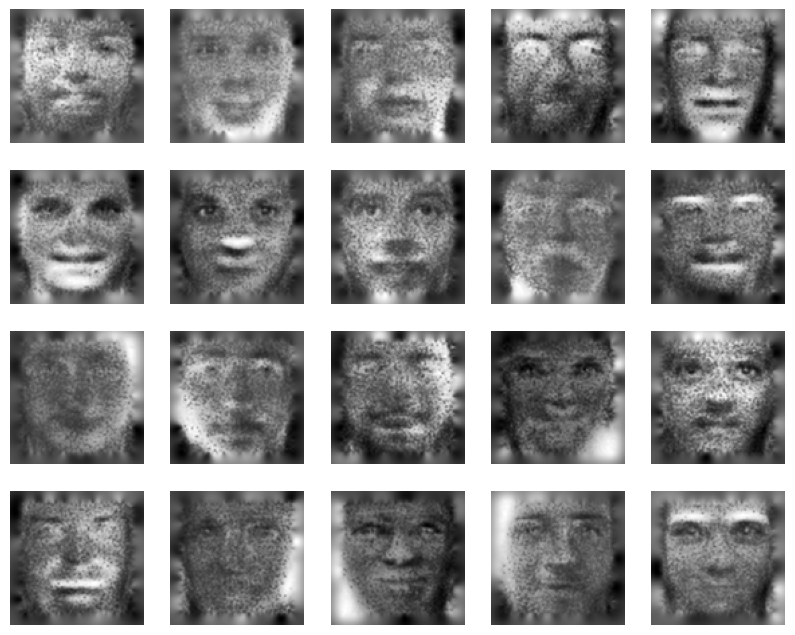

In [104]:
plt.figure(figsize=(10, (L//5) * 2))
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    loading = prediction[:,i].detach().numpy()
    plt.imshow(loading.reshape(newN, newN), cmap='gray')
    plt.axis('off')